# ゼロから作るDeep Learning

## 4章 ニューラルネットワークの学習

### 4.4 勾配

- $x_0$と$x_1$の偏微分をまとめて計算する
- たとえば $x_0=3,x_1=4$のときの$(x_0, x_1)$の両方の偏微分をまとめて、
$\left(\frac{\partial f}{\partial x_0},\frac{\partial f}{\partial x_1}\right)$として計算する

- $\left(\frac{\partial f}{\partial x_0},\frac{\partial f}{\partial x_1}\right)$のように、すべての変数の偏微分をベクトルとしてまとめたものを勾配(gradient)という。

In [1]:
import numpy as np

# 勾配の実装例
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # xと同じ形状の配列を生成
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値を元に戻す
        
    return grad
        

In [3]:
# 実装
def function_2(x):
    return x[0]**2 + x[1]**2
    # または
    # return np.sum(x**2)

##### function_2のグラフ

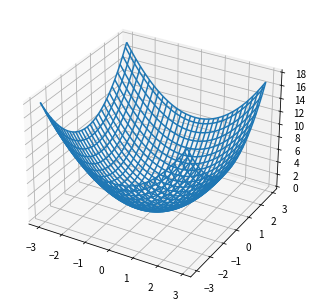

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x0 = np.arange(-3, 3, 0.1)
x1 = np.arange(-3, 3, 0.1)
X0, X1 = np.meshgrid(x0, x1)
Y = X0 ** 2 + X1 ** 2

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X0,X1,Y)
plt.show()

In [7]:
numerical_gradient(function_2,np.array([3.0,4.0]))

array([6., 8.])

In [8]:
numerical_gradient(function_2,np.array([0.0,2.0]))

array([0., 4.])

In [9]:
numerical_gradient(function_2,np.array([3.0,0.0]))

array([6., 0.])

#### gradient_2d.py

No handles with labels found to put in legend.


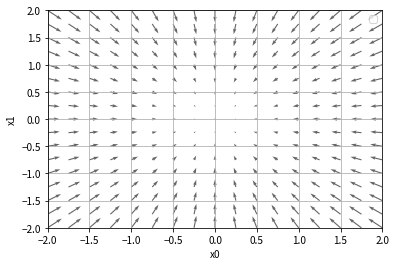

In [10]:
# coding: utf-8
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()

#### 4.4.1 勾配法

- 機械学習では最適なパラメータを探索する(学習することで見つけ出す)
- ニューラルネットワークでは重みとバイアス(の最適値)を探す
- 勾配を利用して、関数の最小値(最小というよりは、できるだけ小さな値=極小値)
- 勾配の指す先に進めば、より小さな値に近づけるはずだが、それが関数全体の最小値とは限らない
- なぜならば
  - デコボコした複雑な関数の場合、そこが最小値とは限らない
  - 最大値かもしれない(見る方向によっては、最小値=最大値)
- すなわち見つけ出せるのは「鞍点」に過ぎない
  - 関数が複雑なとき「プラトー」に陥ることがある(学習が進まない状態)
- それでもまあ、この方法なら、値を減らせることは間違いないので、まずはこれで良しとする、という方法。



- 数式で表す

$$
x_0 = x_0 - \eta\frac{\partial f}{\partial x_0}
$$
$$
x_1 = x_1 - \eta\frac{\partial f}{\partial x_1}
$$
- ここで$ \eta\ $は更新量
   - ニューラルネットワークの学習においては**学習率**と呼ばれる
   - １回の学習で、どれだけ学習すべきか、どれだけパラメータを更新するか、ということを決める
   



- 勾配降下法のPython実装


In [11]:
# fは最適化したい関数
# init_xは初期値
# lr はlearning rate 学習率
# step_numは勾配法による繰り返しの数
# この関数で求められるのは「極小値」（うまく行けば最小値）
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

- 問: $ f(x_0,x_1) = x_0^2 + x_1^2 $の最小値を勾配法で求めよ。


In [12]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [13]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

- 勾配法による更新のプロセスの図示化(ch04/gradient_method.py)

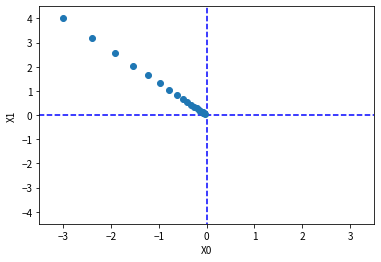

In [14]:
# coding: utf-8
import numpy as np
import matplotlib.pylab as plt
# from gradient_2d import numerical_gradient


def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()


#### 学習率の違いによる結果の実験

In [15]:
# fは最適化したい関数
# init_xは初期値
# lr はlearning rate 学習率
# step_numは勾配法による繰り返しの数
# この関数で求められるのは「極小値」（うまく行けば最小値）
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [16]:
# 学習率が大きすぎる例：lr=10.0  -> 大きな値に発散してしまう
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

array([-2.58983747e+13, -1.29524862e+12])

In [17]:
# 学習率が小さすぎる例：lr = 1e-10  -> ほとんど更新されない
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

#### 学習率の違いによる結果の実験の可視化

In [19]:
def gradient_descent_history(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

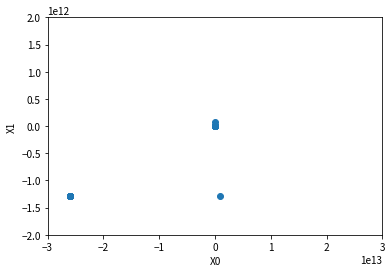

In [20]:
# 学習率が大きすぎる例：lr=10.0
init_x = np.array([-3.0, 4.0])    
lr = 10.0
step_num = 100
x, x_history = gradient_descent_history(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3e+13, 3e+13) ## 変えた
plt.ylim(-2e+12, 2e+12) ## 変えた
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

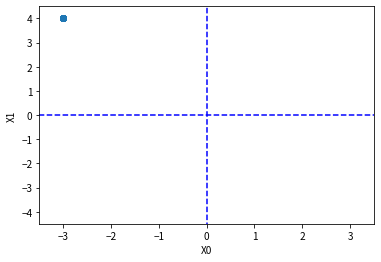

In [22]:
# 学習率が小さすぎる例：lr = 1e-10
init_x = np.array([-3.0, 4.0])    
lr = 1e-10
step_num = 100
x, x_history = gradient_descent_history(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

#### 4.4.2 ニューラルネットワークに対する勾配

- たとえば、形状が２ｘ３で、重みＷだけを持つニューラルネットワークにおいて損失関数をＬで表す場合を考える
- 勾配は$ \frac{\partial L}{\partial W} $

$$
W = \left(
        \begin{array}{ccc}
            w_{11} & w_{12} & w_{13} \\
            w_{21} & w_{22} & w_{23} \\
        \end{array}
    \right)
$$

$$
\frac{\partial L}{\partial W} = 
    \left(
        \begin{array}{ccc}
            \frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}} \\
            \frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}} \\
        \end{array}
    \right)
$$

- $ 2 \times 3 $ の簡単なニューラルネットワークsimpleNetクラスの実装

In [24]:

%cd ../deep-learning-from-scratch/ch04

/mnt/wd500/gotowork/workspace/study-dl-from-scratch/deep-learning-from-scratch/ch04


In [25]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布で初期化
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)
        
        return loss

In [26]:
net = simpleNet()
print(net.W) # 重みパラメータ

[[ 0.52692013 -0.14862265 -0.35157168]
 [ 0.91887554 -0.13667418  1.5389342 ]]


In [28]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[ 1.14314006 -0.21218035  1.17409777]


In [29]:
np.argmax(p) # 最大値のインデックス

2

In [30]:
t = np.array([0,0,1]) # 正解ラベル
net.loss(x, t)

0.7972910235508889

- 勾配を求めてみる

In [31]:
def f(W):
    return net.loss(x, t)

In [32]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.26208804  0.06758324 -0.32967129]
 [ 0.39313206  0.10137487 -0.49450693]]


##### lambda記法

In [33]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

In [34]:
print(dW)

[[ 0.26208804  0.06758324 -0.32967129]
 [ 0.39313206  0.10137487 -0.49450693]]


## 4.5 学習アルゴリズムの実装

### 4.5.1 2層ニューラルネットワークのクラス

2層のニューラルネットワーク（隠れ層が1層のニューラルネットワーク）を対象に、MNISTデータセットを使って学習を行う

In [33]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import *
from common.gradient import numerical_gradient

In [34]:
class TwoLayerNet:
    # このクラスで使用する変数
    ## params : ニューラルネットワークのパラメータを保持するディクショナリ変数（インスタンス変数）
    ##          params['W1']は1層目の重み、params['b1']は1層目のバイアス。
    ##          params['W2']は2層目の重み、params['b2']は2層目のバイアス。
    #
    ## grads : 勾配を保持するディクショナリ変数（numerical_gradient()メソッドの返り値）
    ##         grads['W1']は1層目の重みの勾配、grads['b1']は1層目のバイアスの勾配。
    ##         grads['W2']は2層目の重みの勾配、grads['b2']は2層目のバイアスの勾配。
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y,t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    

#### 一つ例を見てみる

In [35]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [36]:
net.params['W1'].shape # 今の層（入力層）のニューロン数×次の層（隠れ層）ニューロン数の行列になる

(784, 100)

In [37]:
net.params['b1'].shape # 次の層（隠れ層）のニューロン数の行列になる

(100,)

In [38]:
net.params['W2'].shape # 今の層（隠れ層）のニューロン数×次の層（出力層）のニューロン数の行列になる

(100, 10)

In [39]:
net.params['b2'].shape # 次の層（出力層）のニューロン数の行列になる

(10,)

#### 推論処理の例

In [40]:
x = np.random.rand(100, 784) # ダミーの入力データ（１００枚分）
y = net.predict(x)

In [41]:
x

array([[ 0.50188056,  0.96517037,  0.05350728, ...,  0.56825998,
         0.98600559,  0.67104001],
       [ 0.16978641,  0.14051161,  0.52971885, ...,  0.82606713,
         0.99340502,  0.62187936],
       [ 0.86669792,  0.05412285,  0.91682105, ...,  0.14892752,
         0.28758397,  0.92739735],
       ..., 
       [ 0.55574574,  0.17256048,  0.95276649, ...,  0.40188372,
         0.53380328,  0.63977913],
       [ 0.75456821,  0.0031351 ,  0.75581799, ...,  0.21401964,
         0.45407314,  0.25185785],
       [ 0.40112342,  0.42731279,  0.40969708, ...,  0.93685891,
         0.06094924,  0.48367401]])

In [42]:
y

array([[ 0.09925495,  0.10465804,  0.1015886 ,  0.09537274,  0.08734547,
         0.10667396,  0.10356811,  0.10907824,  0.09630761,  0.09615227],
       [ 0.09921967,  0.10439457,  0.10202756,  0.09537335,  0.08749929,
         0.10672752,  0.10373257,  0.10885834,  0.09608248,  0.09608463],
       [ 0.09909723,  0.10446829,  0.10162464,  0.09532865,  0.08746435,
         0.10623734,  0.10414929,  0.10891766,  0.09596607,  0.09674648],
       [ 0.09913774,  0.10448548,  0.10184351,  0.09530654,  0.08745371,
         0.10679056,  0.1035598 ,  0.10871209,  0.09634192,  0.09636865],
       [ 0.09917044,  0.1044664 ,  0.10217217,  0.09543875,  0.08741966,
         0.10625806,  0.10382361,  0.10890929,  0.09598497,  0.09635663],
       [ 0.0995868 ,  0.10496204,  0.10161918,  0.0955518 ,  0.08727704,
         0.10608217,  0.1035924 ,  0.10927696,  0.09594841,  0.09610322],
       [ 0.09930662,  0.10429476,  0.10185892,  0.09552933,  0.0875734 ,
         0.10635255,  0.10382917,  0.10876407

In [43]:
x = np.random.rand(100, 784) # ダミーの入力データ(100枚分)
t = np.random.rand(100, 10)  # ダミーの正解ラベル(100枚分)

grads = net.numerical_gradient(x, t) # 勾配を計算  5分くらいかかった

In [44]:
grads['W1'].shape 

(784, 100)

In [45]:
grads['b1'].shape

(100,)

In [46]:
grads['W2'].shape 

(100, 10)

In [47]:
grads['b2'].shape

(10,)

### ミニバッチ学習の実装

In [48]:
import numpy as np
from dataset.mnist import load_mnist

In [49]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

In [50]:
# ハイパーパラメータ
ters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [51]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [56]:
from datetime import datetime
for i in range(iters_num):
    print(datetime.now(),"start",i)
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    print(datetime.now(),"calculating gradient..",i)
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = nework.gradient(..) # 高速版
    
    # パラメータの更新
    print(datetime.now(),"updating params..",i)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 学習経過の記録
    print(datetime.now(),"recording loss..",i)
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
# 10時間以上経っても終わらず。


2018-05-30 18:39:08.343208 start 0
2018-05-30 18:39:08.344094 calculating gradient.. 0
2018-05-30 18:40:23.406740 updating params.. 0
2018-05-30 18:40:23.407532 recording loss.. 0
2018-05-30 18:40:23.409224 start 1
2018-05-30 18:40:23.410108 calculating gradient.. 1
2018-05-30 18:41:38.883205 updating params.. 1
2018-05-30 18:41:38.883843 recording loss.. 1
2018-05-30 18:41:38.885360 start 2
2018-05-30 18:41:38.886108 calculating gradient.. 2
2018-05-30 18:42:54.395831 updating params.. 2
2018-05-30 18:42:54.396600 recording loss.. 2
2018-05-30 18:42:54.398102 start 3
2018-05-30 18:42:54.398641 calculating gradient.. 3
2018-05-30 18:44:10.213235 updating params.. 3
2018-05-30 18:44:10.213902 recording loss.. 3
2018-05-30 18:44:10.215409 start 4
2018-05-30 18:44:10.215983 calculating gradient.. 4


KeyboardInterrupt: 

- 0:01:15 / loop
- 75sec / loop
- 10,000 loopだと
  - 75,000 sec
  - 1,250 min
  - 20.8 hour


### 4.5.3 テストデータで評価

In [60]:
import numpy as np
from dataset.mnist import load_mnist

In [61]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

train_size = x_train.shape[0]
train_loss_list = []
train_acc_list = []
test_acc__list = []
# 1エポックあたりの繰り返し数
iter_per_epoch = max(train_size / batch_size, 1)


In [62]:
# ハイパーパラメータ
iters_num = 10000
batch_size = 100
learning_rate = 0.1


In [63]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [64]:
from datetime import datetime
for i in range(iters_num):
    print(datetime.now(),"start",i)
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    print(datetime.now(),"calculating gradient..",i)
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = nework.gradient(..) # 高速版
    
    # パラメータの更新
    print(datetime.now(),"updating params..",i)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 学習経過の記録
    print(datetime.now(),"recording loss..",i)
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1エポックごとに認識精度を計算
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc__list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + "," +str(test_acc))


2018-05-30 19:05:41.326270 start 0
2018-05-30 19:05:41.327250 calculating gradient.. 0
2018-05-30 19:06:59.391969 updating params.. 0
2018-05-30 19:06:59.392604 recording loss.. 0
train acc, test acc | 0.100983333333,0.1003
2018-05-30 19:07:00.169775 start 1
2018-05-30 19:07:00.170555 calculating gradient.. 1
2018-05-30 19:08:18.287752 updating params.. 1
2018-05-30 19:08:18.288498 recording loss.. 1
2018-05-30 19:08:18.290601 start 2
2018-05-30 19:08:18.291282 calculating gradient.. 2
2018-05-30 19:09:35.520129 updating params.. 2
2018-05-30 19:09:35.521195 recording loss.. 2
2018-05-30 19:09:35.522597 start 3
2018-05-30 19:09:35.523180 calculating gradient.. 3
2018-05-30 19:10:53.301385 updating params.. 3
2018-05-30 19:10:53.302177 recording loss.. 3
2018-05-30 19:10:53.303760 start 4
2018-05-30 19:10:53.304647 calculating gradient.. 4
2018-05-30 19:12:10.802603 updating params.. 4
2018-05-30 19:12:10.803771 recording loss.. 4
2018-05-30 19:12:10.805571 start 5
2018-05-30 19:12:10.8

KeyboardInterrupt: 